# Data Preprocessing for Stock Price Prediction
### This NoteBook loads stock price data, performs cleaning, feature engineering, scaling, and sequence creation for LSTM model training.
### The processed data will be saved for use in the LSTM training .

## 1. Load and Inspect Data

### Load the stock price data from a CSV file and perform initial inspection and cleaning.

In [1]:
import pandas as pd
data = pd.read_csv("../data/Google.csv")
df = pd.DataFrame(data=data)
print(df.head())

df.rename(columns={'Unnamed: 0': 'timestamp'}, inplace=True)
print(df.isnull().sum())
df['timestamp'] = pd.to_datetime(df['timestamp'])
print(df.info())
df.set_index('timestamp', inplace=True)
if df.index.duplicated().any():
    print(f"\nFound {df.index.duplicated().sum()} duplicate timestamps. Removing duplicates...")
    df = df[~df.index.duplicated(keep='first')]
    print("Duplicates removed. DataFrame head:")
    print(df.head())
else:
    print("\nNo duplicate timestamps found.")
print(df.head())


   Unnamed: 0       open       high        low      close   adjclose  \
0  2016-01-04  37.150002  37.202999  36.562901  37.091999  37.091999   
1  2016-01-05  37.322498  37.599998  36.931999  37.129002  37.129002   
2  2016-01-06  36.500000  37.359001  36.445999  37.181000  37.181000   
3  2016-01-07  36.515499  36.924999  35.952999  36.319500  36.319500   
4  2016-01-08  36.572498  36.661499  35.650002  35.723499  35.723499   

     volume ticker  
0  65456000   GOOG  
1  39014000   GOOG  
2  38940000   GOOG  
3  59274000   GOOG  
4  49018000   GOOG  
timestamp    0
open         0
high         0
low          0
close        0
adjclose     0
volume       0
ticker       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2113 entries, 0 to 2112
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  2113 non-null   datetime64[ns]
 1   open       2113 non-null   float64       
 2   high     

## 2. Create Dummy Data

### For testing purposes, create a dummy dataset to ensure reproducibility. In a real scenario, use the actual data loaded above.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
date_range = pd.date_range(start='2016-01-01', periods=200, freq='B')  # 200 business days
np.random.seed(42)
dummy_data = {
    'open': np.random.uniform(30, 50, 200).cumsum() + 100,
    'high': np.random.uniform(30, 50, 200).cumsum() + 101,
    'low': np.random.uniform(30, 50, 200).cumsum() + 99,
    'close': np.random.uniform(30, 50, 200).cumsum() + 100,
    'adjclose': np.random.uniform(30, 50, 200).cumsum() + 100,
    'volume': np.random.randint(10_000_000, 100_000_000, 200),
    'ticker': ['GOOG'] * 200
}

### Adjust high, low relative to open/close for realism

In [3]:
dummy_data['high'] = np.maximum(dummy_data['open'], dummy_data['close']) + np.random.uniform(0.5, 2, 200)
dummy_data['low'] = np.minimum(dummy_data['open'], dummy_data['close']) - np.random.uniform(0.5, 2, 200)

df = pd.DataFrame(dummy_data, index=date_range)
df.index.name = 'timestamp'
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 200 entries, 2016-01-01 to 2016-10-06
Freq: B
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   open      200 non-null    float64
 1   high      200 non-null    float64
 2   low       200 non-null    float64
 3   close     200 non-null    float64
 4   adjclose  200 non-null    float64
 5   volume    200 non-null    int64  
 6   ticker    200 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 12.5+ KB
None


## 3. Feature Engineering

### Add technical indicators like daily returns, moving averages, and volatility to enrich the dataset.

In [4]:
target_column = 'close'

# 1. Daily Returns
df['daily_return'] = df[target_column].pct_change()

# 2. Simple Moving Averages (SMA) - common lags 20, 50
df['SMA_20'] = df[target_column].rolling(window=20).mean()
df['SMA_50'] = df[target_column].rolling(window=50).mean()

# 3. Exponential Moving Averages (EMA) - often more responsive
df['EMA_20'] = df[target_column].ewm(span=20, adjust=False).mean()
df['EMA_50'] = df[target_column].ewm(span=50, adjust=False).mean()

# 4. Volatility (Standard Deviation of returns over a period)
df['volatility_20'] = df['daily_return'].rolling(window=20).std()

# Remove rows with NaN values created by rolling windows
df.dropna(inplace=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 151 entries, 2016-03-10 to 2016-10-06
Freq: B
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   open           151 non-null    float64
 1   high           151 non-null    float64
 2   low            151 non-null    float64
 3   close          151 non-null    float64
 4   adjclose       151 non-null    float64
 5   volume         151 non-null    int64  
 6   ticker         151 non-null    object 
 7   daily_return   151 non-null    float64
 8   SMA_20         151 non-null    float64
 9   SMA_50         151 non-null    float64
 10  EMA_20         151 non-null    float64
 11  EMA_50         151 non-null    float64
 12  volatility_20  151 non-null    float64
dtypes: float64(11), int64(1), object(1)
memory usage: 16.5+ KB
None


## 4. Visualize Data

### Plot the close price, moving averages, volume, and daily returns to understand the data.

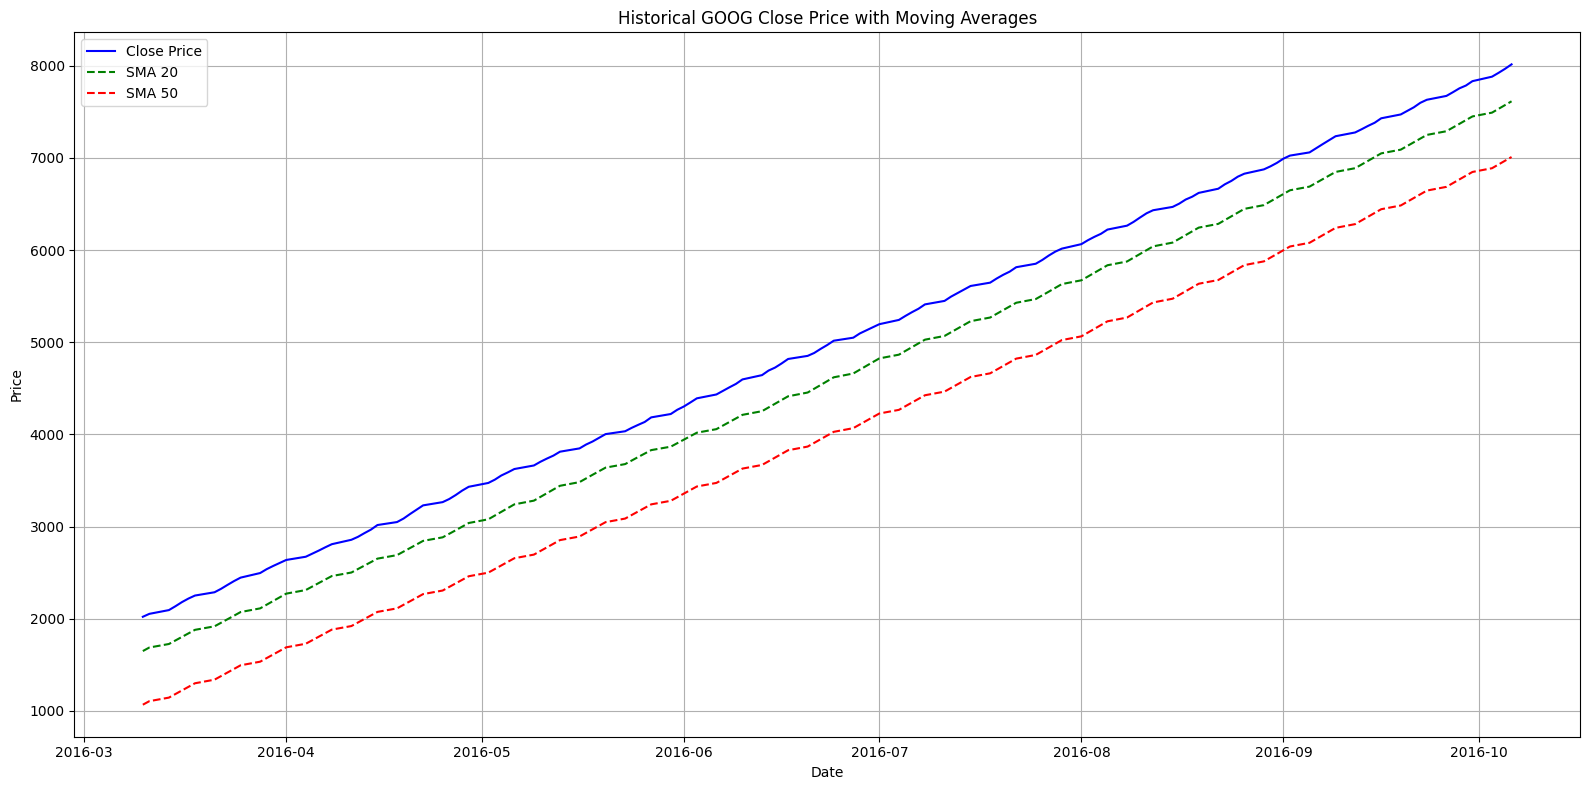

In [5]:
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['close'], label='Close Price', color='blue')
plt.plot(df.index, df['SMA_20'], label='SMA 20', color='green', linestyle='--')
plt.plot(df.index, df['SMA_50'], label='SMA 50', color='red', linestyle='--')
plt.title(f'Historical {df["ticker"].iloc[0]} Close Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

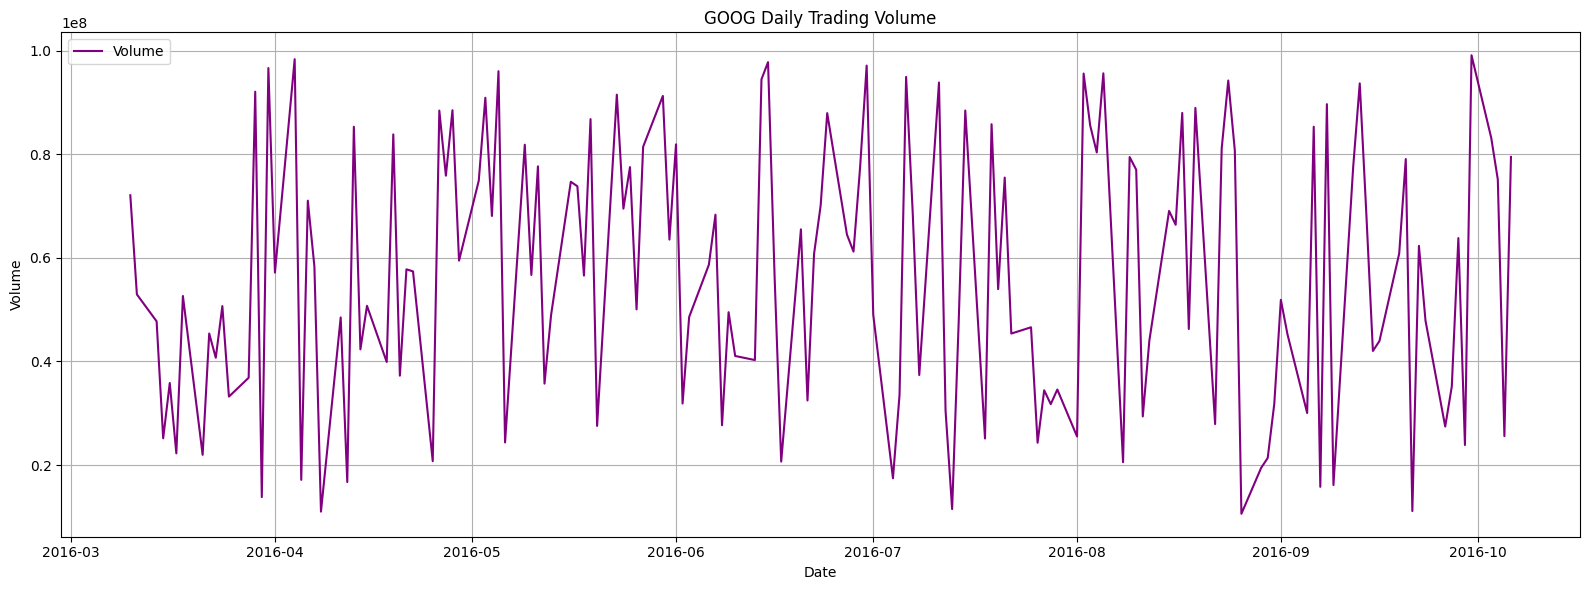

In [6]:
plt.figure(figsize=(16, 6))
plt.plot(df.index, df['volume'], label='Volume', color='purple')
plt.title(f'{df["ticker"].iloc[0]} Daily Trading Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

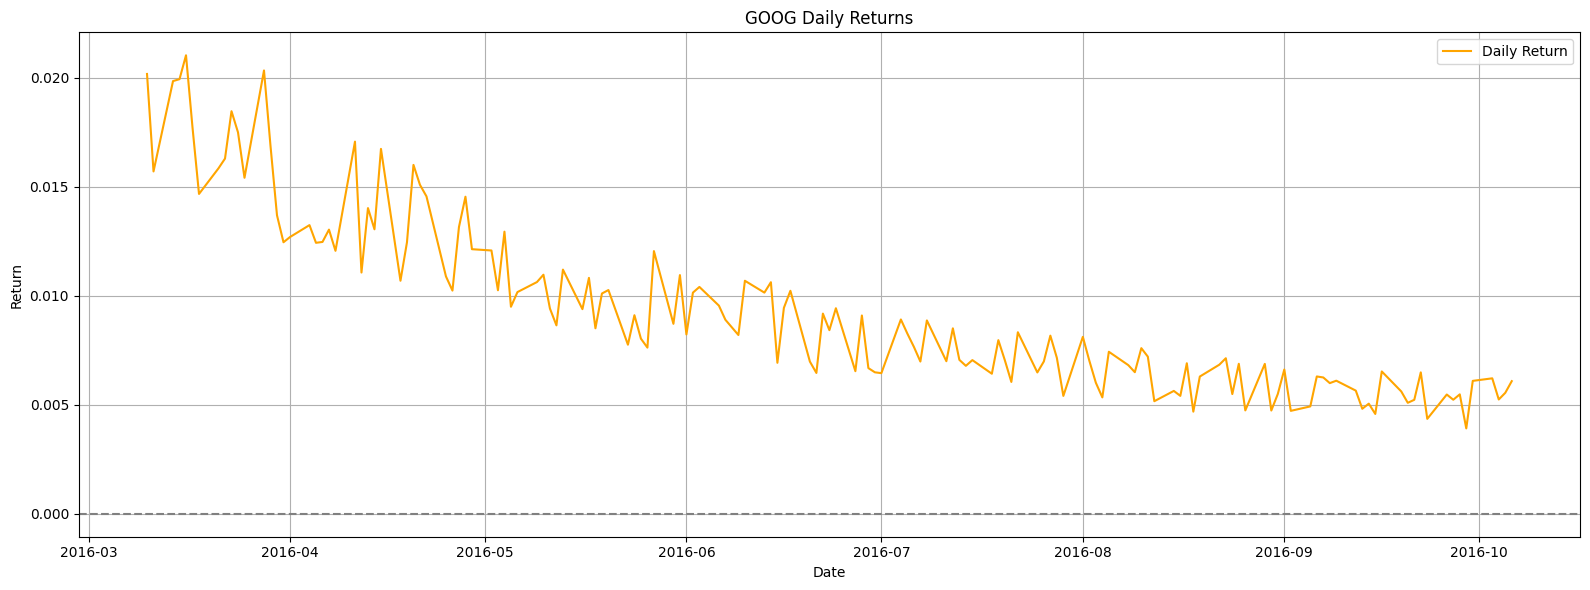

In [7]:
plt.figure(figsize=(16, 6))
plt.plot(df.index, df['daily_return'], label='Daily Return', color='orange')
plt.title(f'{df["ticker"].iloc[0]} Daily Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 5. Scale Features


### Scale numerical features to the range [0, 1] using MinMaxScaler.

In [8]:
features_to_scale = [col for col in df.columns if col not in ['ticker']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[features_to_scale])
scaled_df = pd.DataFrame(scaled_data, columns=features_to_scale, index=df.index)

print("\nScaled DataFrame head (only showing first 5 rows and selected columns for brevity):")
print(scaled_df.head())
print("\nDescriptive statistics of scaled data:")
print(scaled_df.describe())


Scaled DataFrame head (only showing first 5 rows and selected columns for brevity):
                open      high       low     close  adjclose    volume  \
timestamp                                                                
2016-03-10  0.000000  0.000000  0.000000  0.000000  0.000000  0.694704   
2016-03-11  0.008246  0.008168  0.005220  0.005296  0.005356  0.478470   
2016-03-14  0.015842  0.015707  0.011984  0.012094  0.013046  0.419758   
2016-03-15  0.023987  0.023903  0.018858  0.019059  0.018890  0.164606   
2016-03-16  0.031983  0.031887  0.026525  0.026552  0.027086  0.285207   

            daily_return    SMA_20    SMA_50    EMA_20    EMA_50  \
timestamp                                                          
2016-03-10      0.949897  0.000000  0.000000  0.000000  0.000000   
2016-03-11      0.688659  0.006448  0.006465  0.006440  0.005743   
2016-03-14      0.930753  0.012835  0.012947  0.012918  0.011536   
2016-03-15      0.935958  0.019235  0.019456  0.019445  

# 6. Create Sequences for LSTM



### Create sequences of past `timesteps` days to predict the next day's close price.

In [9]:
timesteps = 60
X = []
y = []
target_feature_index = scaled_df.columns.get_loc(target_column)

for i in range(timesteps, len(scaled_df)):
    X.append(scaled_df.iloc[i-timesteps:i].values)
    y.append(scaled_df.iloc[i, target_feature_index])

X = np.array(X)
y = np.array(y)

print(f"\nShape of X (sequences): {X.shape}")
print(f"Shape of y (target values): {y.shape}")


Shape of X (sequences): (91, 60, 12)
Shape of y (target values): (91,)


## 7. Train-Test Split

### Split the sequences into training and testing sets chronologically.

In [10]:
train_split_ratio = 0.8
train_size = int(len(X) * train_split_ratio)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

print("\n--- Preprocessing and Data Preparation Complete ---")
print("You now have X_train, y_train, X_test, y_test ready for LSTM model training.")
print("The 'scaler' object is also preserved for inverse transforming predictions later.")


Shape of X_train: (72, 60, 12)
Shape of y_train: (72,)
Shape of X_test: (19, 60, 12)
Shape of y_test: (19,)

--- Preprocessing and Data Preparation Complete ---
You now have X_train, y_train, X_test, y_test ready for LSTM model training.
The 'scaler' object is also preserved for inverse transforming predictions later.


## 8. Save Processed Data

### Save the processed data and scaler for use in the LSTM training script.

In [12]:
import joblib
path = '../data/'
np.save(path+'X_train.npy', X_train)
np.save(path+'X_test.npy', X_test)
np.save(path+'y_train.npy', y_train)
np.save(path+'y_test.npy', y_test)
joblib.dump(scaler, path+'scaler.pkl')
joblib.dump(features_to_scale, path+'features_to_scale.pkl')
print("\nSaved X_train, X_test, y_train, y_test, scaler, and features_to_scale.")


Saved X_train, X_test, y_train, y_test, scaler, and features_to_scale.
